In [1]:
import os
from os import listdir, makedirs
from os.path import join, isfile, isdir, splitext
from PIL import Image
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Unzip Flickr data

In [2]:
from utils.prep import load_images_list
from zipfile import ZipFile

# Extract Data
if not os.path.exists('./Flickr_Data.zip'):
    raise Exception('Dataset not found. Please read instructions above this cell and download dataset.')

if not os.path.exists('./Flickr_Data'):
    print("Extracting data ...")
    ZipFile('./Flickr_Data.zip', 'r').extractall('./')

#Files with names of corresponding images
train_image_list_path = './Flickr_Data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_image_list_path = './Flickr_Data/Flickr8k_text/Flickr_8k.testImages.txt'

train_image_list = load_images_list(train_image_list_path)
test_image_list = load_images_list(test_image_list_path)

print('Total train images:',len(train_image_list))
print('Total test images:', len(test_image_list))

Total train images: 6000
Total test images: 1000


In [3]:
images_path = './Flickr_Data/Flickr8k_Dataset'
filename='667626_18933d713e.jpg'

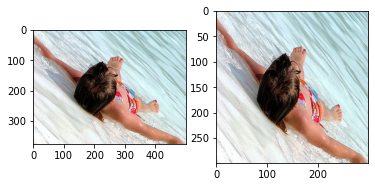

In [4]:
img=Image.open(join(images_path,filename))
f=plt.figure()
f.add_subplot(1,2,1)
plt.imshow(img)
img=img.resize((299,299))
f.add_subplot(1,2,2)
plt.imshow(img)
plt.show()

# Resize all Images to 299x299

In [5]:
from utils.resize import ImageResizer
images_path = './Flickr_Data/Flickr8k_Dataset'
resized_dir='./Flickr_Data/resized'
size=(299,299)
resizer=ImageResizer(source_dir=images_path,
                    dest_dir=resized_dir).resize_all(size=size)

Resized images already exist


In [6]:
dev_list = './Flickr_Data/Flickr8k_text/Flickr_8k.devImages.txt'
test_list = './Flickr_Data/Flickr8k_text/Flickr_8k.testImages.txt'
train_list = './Flickr_Data/Flickr8k_text/Flickr_8k.trainImages.txt'

# Convert to Incep-Resnet-v2 records

In [7]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3940996916908776463
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2234500744180777898
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7041626944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15916712446227477266
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6033403133377622961
physical_device_desc: "device: XLA_GPU device"
]


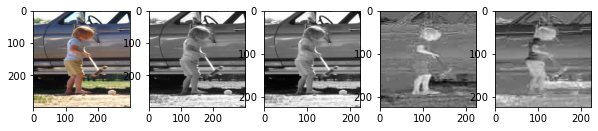

In [8]:
from utils.prep import prep_for_inception, RGB_to_lab

train1=join(resized_dir,'2903617548_d3e38d7f88.jpg')
img1=Image.open(train1)
f=plt.figure(figsize=(10,10))
f.add_subplot(1,5,1)
plt.imshow(img1)
incep_img=prep_for_inception(np.asarray(img1))
f.add_subplot(1,5,2)
plt.imshow(incep_img[0])
l_img,ab_img=RGB_to_lab(np.asarray(img1))
f.add_subplot(1,5,3)
plt.imshow(l_img[0],cmap='gray')
f.add_subplot(1,5,4)
plt.imshow(ab_img[0,:,:,0],cmap='gray')
f.add_subplot(1,5,5)
plt.imshow(ab_img[0,:,:,1],cmap='gray')

In [9]:
from utils.tfrecord_writer import tfrecordwriter
train_list = './Flickr_Data/Flickr8k_text/Flickr_8k.trainImages.txt'
resized_dir = './Flickr_Data/resized'
img_list = train_list
record_path = './tfrecords/'
file_name='train.tfrecords'
tfrecordwriter(resized_dir, img_list, record_path, file_name)

Successfully write 6000 records, stored at ./tfrecords/train.tfrecords


# Read From tfrecord

In [10]:
from utils.tfrecord_reader import batch_reader
record_path = './tfrecords/'
record_file = 'train.tfrecords'
batch_size = 1
train_batch_generator = batch_reader(batch_size, record_path, record_file)

In [11]:
train_batch=next(train_batch_generator)
test_l, test_emb=train_batch[0]
test_ab=train_batch[1]
test_truth=tf.concat([test_l*100,test_ab*127], 3)
test_truth=color.lab2rgb(test_truth)

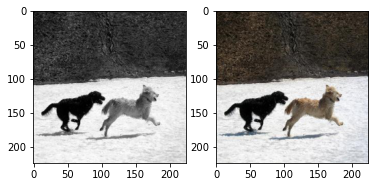

In [12]:
f=plt.figure()
f.add_subplot(1,2,1)
plt.imshow(test_l[0],cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(test_truth[0])
plt.show()

# Train model

In [33]:
from utils.tfrecord_reader import batch_reader
record_path = './tfrecords/'
record_file = 'train.tfrecords'
batch_size = 100
train_batch_generator=batch_reader(batch_size, record_path, record_file)

In [34]:
from utils.network import deep_color
history=deep_color.fit(train_batch_generator, epochs=20, steps_per_epoch=30)

Epoch 1/20
30/30 [==============================] - 250s 8s/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0759
Epoch 2/20
30/30 [==============================] - 235s 8s/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0764
Epoch 3/20
30/30 [==============================] - 245s 8s/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0757
Epoch 4/20
30/30 [==============================] - 241s 8s/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0758
Epoch 5/20
30/30 [==============================] - 238s 8s/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0751
Epoch 6/20
30/30 [==============================] - 262s 9s/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0753
Epoch 7/20
30/30 [==============================] - 602s 20s/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0749
Epoch 8/20
30/30 [==============================] - 602s 20s/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0750
Epoch 9/20
30/30 [==============================] - 651s 22s/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0748
Epoch 10/20
30/30 [======

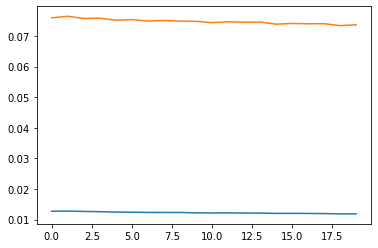

In [35]:
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])

In [150]:
deep_color.save('saved_model/deep_Flickr')
deep_color.save_weights('./checkpoints/deep_Flickr_weights')

INFO:tensorflow:Assets written to: saved_model/deep_Flickr\assets


# Get train case

In [36]:
record_path = './tfrecords/'
train_file = 'train.tfrecords'
batch_size = 1 
test_generator=batch_reader(batch_size, record_path, train_file)

In [143]:
test_img=next(test_generator)
test_l, test_emb=test_img[0]
test_ab=test_img[1]

In [144]:
test_pred=deep_color.predict([test_l,test_emb])

In [145]:
test_result=tf.concat([test_l*100,test_pred*127], 3)
test_result=color.lab2rgb(test_result)
test_truth=tf.concat([test_l*100,test_ab*127], 3)
test_truth=color.lab2rgb(test_truth)

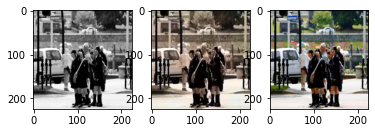

In [146]:
f=plt.figure()
f.add_subplot(1,3,1)
plt.imshow(test_l[0],cmap='gray')
f.add_subplot(1,3,2)
plt.imshow(test_result[0])
f.add_subplot(1,3,3)
plt.imshow(test_truth[0])
plt.show()

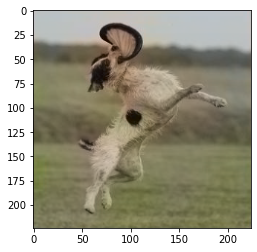

In [98]:
plt.imshow(test_result[0])
plt.savefig('testcase5.jpeg')